<a href="https://colab.research.google.com/github/lillyschroeder/DL_final_project/blob/main/DeepMoji_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

# DeepMoji Reimplementation

# Preprocessing (Pretraining Task)

In [ ]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [ ]:
import string
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
import re
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import numpy as np
from tqdm import tqdm

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.5 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

In [ ]:
tweets_dataset = load_dataset('tweet_eval', 'emoji')

train_data = tweets_dataset['train']
validation_data = tweets_dataset['validation']
test_data = tweets_dataset['test']

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/45000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/emoji/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
names = [
                "❤",
                "😍",
                "😂",
                "💕",
                "🔥",
                "😊",
                "😎",
                "✨",
                "💙",
                "😘",
                "📷",
                "🇺🇸",
                "☀",
                "💜",
                "😉",
                "💯",
                "😁",
                "🎄",
                "📸",
                "😜",
            ]

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess(text: str) -> list[str]:
  """
  Converts text to lowercase, removes punctuation and special characters.
  Tokenizes and removes stopwords.

  Parameters:
    text  tweets
  Returns:
    a list of tokens
  """
  text = text.lower()
  text = re.sub(r'@(\S+|\s?)', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  text = re.sub(r'\W+', ' ', text)
  text = ''.join([c for c in text if c not in string.punctuation])
  #tokens = [word for word in text.split() if word not in stop_words]

  tokens = [stemmer.stem(word) for word in text.split() if word not in stop_words]
    
  return tokens

In [ ]:
def build_vocab(texts, max_vocab_size=1000) -> tuple[dict[str, int], dict[int, str]]:
  """
  Builds a vocabulary from a list of tokenized texts.

  Parameters:
      texts (List[List[str]]): A list of tokenized texts (a list of lists of words)
      max_vocab_size (int, optional): The maximum number of words to include in the vocabulary

  Returns:
      Tuple[Dict[str, int], Dict[int, str]]: A tuple containing two dictionaries:
          - word_to_idx (Dict[str, int]): A dictionary that maps each unique word to a unique integer index.
          - idx_to_word (Dict[int, str]): A dictionary that maps each integer index back to the corresponding word.
    """
  word_counts = Counter()
    
  for text in texts:
    for word in text:
      word_counts[word] += 1
            
  vocab = sorted(word_counts, key=word_counts.get, reverse=True)

  if max_vocab_size is not None:
    vocab = vocab[:max_vocab_size - 2]
    
  #word_to_idx = {'<unk>': 0}
  word_to_idx = {'<pad>': 0, '<unk>': 1}
  #for idx, word in enumerate(vocab, start=1):
  for idx, word in enumerate(vocab, start=2):
    word_to_idx[word] = idx
    
  idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    
  return word_to_idx, idx_to_word

In [ ]:
train_texts = train_data['text']
train_labels = train_data['label']
preprocessed_texts = [preprocess(text) for text in train_texts]
print(train_texts[0])
print(preprocessed_texts[0])

word_to_idx, idx_to_word = build_vocab(preprocessed_texts)
print(idx_to_word)

text_indices = [[word_to_idx.get(word, 1) for word in text] for text in preprocessed_texts]
max_len = max(len(text) for text in text_indices)
padded_text_indices = [text + [0] * (max_len - len(text)) for text in text_indices]

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(train_labels)

Sunday afternoon walking through Venice in the sun with @user ️ ️ ️ @ Abbot Kinney, Venice
['sunday', 'afternoon', 'walk', 'venic', 'sun', 'abbot', 'kinney', 'venic']
{0: '<pad>', 1: '<unk>', 2: 'california', 3: 'love', 4: 'day', 5: 'la', 6: 'amp', 7: 'happi', 8: 'thank', 9: 'lo', 10: 'san', 11: 'angel', 12: 'beach', 13: 'vega', 14: 'night', 15: 'time', 16: 'today', 17: 'christma', 18: 'beauti', 19: 'get', 20: 'one', 21: 'good', 22: 'new', 23: 'like', 24: 'last', 25: 'ca', 26: 'hollywood', 27: 'park', 28: 'best', 29: 'look', 30: 'friend', 31: 'see', 32: 'famili', 33: 'go', 34: 'birthday', 35: 'disneyland', 36: 'back', 37: 'come', 38: 'got', 39: 'littl', 40: 'fun', 41: 'great', 42: 'year', 43: 'citi', 44: 'francisco', 45: 'make', 46: 'girl', 47: 'life', 48: 'morn', 49: 'work', 50: 'home', 51: 'much', 52: 'favorit', 53: 'tonight', 54: 'seattl', 55: 'alway', 56: 'amaz', 57: 'first', 58: 'diego', 59: 'miss', 60: 'center', 61: 'place', 62: 'take', 63: 'weekend', 64: 'know', 65: 'us', 66: 'g

In [ ]:
val_texts = validation_data['text']
val_labels = validation_data['label']

preprocessed_val_texts = [preprocess(text) for text in val_texts]
val_text_indices = [[word_to_idx.get(word, 1) for word in text] for text in preprocessed_val_texts]
padded_val_text_indices = [text + [0] * (max_len - len(text)) for text in val_text_indices]

print(val_texts[0])
print(preprocessed_val_texts[0])
print(idx_to_word)
print(padded_val_text_indices[0])

A little throwback with my favourite person @ Water Wall
['littl', 'throwback', 'favourit', 'person', 'water', 'wall']
{0: '<pad>', 1: '<unk>', 2: 'california', 3: 'love', 4: 'day', 5: 'la', 6: 'amp', 7: 'happi', 8: 'thank', 9: 'lo', 10: 'san', 11: 'angel', 12: 'beach', 13: 'vega', 14: 'night', 15: 'time', 16: 'today', 17: 'christma', 18: 'beauti', 19: 'get', 20: 'one', 21: 'good', 22: 'new', 23: 'like', 24: 'last', 25: 'ca', 26: 'hollywood', 27: 'park', 28: 'best', 29: 'look', 30: 'friend', 31: 'see', 32: 'famili', 33: 'go', 34: 'birthday', 35: 'disneyland', 36: 'back', 37: 'come', 38: 'got', 39: 'littl', 40: 'fun', 41: 'great', 42: 'year', 43: 'citi', 44: 'francisco', 45: 'make', 46: 'girl', 47: 'life', 48: 'morn', 49: 'work', 50: 'home', 51: 'much', 52: 'favorit', 53: 'tonight', 54: 'seattl', 55: 'alway', 56: 'amaz', 57: 'first', 58: 'diego', 59: 'miss', 60: 'center', 61: 'place', 62: 'take', 63: 'weekend', 64: 'know', 65: 'us', 66: 'guy', 67: 'santa', 68: 'hill', 69: 'show', 70: 'h

# Preprocessing (Retraining Task)

In [ ]:
# Download emotion dataset
emotion_dataset = load_dataset('tweet_eval', 'emotion')
emotion_train_data = emotion_dataset['train']
emotion_validation_data = emotion_dataset['validation']
emotion_test_data = emotion_dataset['test']

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1421 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/374 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
def build_retrain_vocab(texts, max_new_words, word_to_idx):
  """
  Based on the extend_vocab method in the original implementation which can
  be found in this file:
  https://github.com/bfelbo/DeepMoji/blob/master/deepmoji/create_vocab.py

  Returns vocab dictionaries for retrain (emotion) dataset.
  """
  word_counts = Counter()
  for text in texts:
    word_counts.update(text)
   
  word_counts = dict(filter(lambda x: False if x[0] in word_to_idx else True, word_counts.items()))         
  vocab = sorted(word_counts, key=word_counts.get, reverse=True)

  word_to_idx = word_to_idx | dict(zip(vocab[:max_new_words], range(len(word_to_idx), len(word_to_idx) + max_new_words)))
  idx_to_word = {idx: word for word, idx in word_to_idx.items()}
  
  return word_to_idx, idx_to_word

In [ ]:
# Preprocessing emotion train data
emotion_train_texts = emotion_train_data['text']
emotion_train_labels = emotion_train_data['label']
emotion_train_preprocessed_texts = [preprocess(text) for text in emotion_train_texts]

# Build vocab for emotion dataset
emotion_word_to_idx, emotion_idx_to_word = build_retrain_vocab(emotion_train_preprocessed_texts, 600, word_to_idx.copy())
assert len(emotion_word_to_idx) == len(emotion_idx_to_word), "ERROR"
print("Retrain vocab size: " + str(len(emotion_word_to_idx)))
print(emotion_word_to_idx)

def get_emotion_dataloader(emotion_preprocessed_texts, emotion_labels, emotion_word_to_idx, window_size):
  """
  Helper function. Takes in preprocessed texts and labels for train/val/test set
  and word-to-index dictionary and window size. Returns dataloader for
  train/val/test set.
  """
  emotion_text_indices = [[emotion_word_to_idx.get(word, 1) for word in text] for text in emotion_preprocessed_texts]
  emotion_padded_text_indices = [text[:window_size] + [0] * (window_size - len(text)) for text in emotion_text_indices]

  print("First example: " + str(emotion_padded_text_indices[0]) + ", " + str(emotion_labels[0]))
  emotion_dataset = TensorDataset(torch.tensor(emotion_padded_text_indices, dtype=torch.long), torch.tensor(emotion_labels, dtype=torch.long))
  emotion_dataloader = DataLoader(emotion_dataset, batch_size=100, shuffle=True)

  return emotion_dataloader

window_size = max(len(text) for text in emotion_train_preprocessed_texts)
print("Window size for retraining dataset: " + str(window_size))
print()
print("Train set")
emotion_train_dataloader = get_emotion_dataloader(emotion_train_preprocessed_texts, 
                                                  emotion_train_labels, emotion_word_to_idx, 
                                                  window_size)

# Preprocessing emotion validation data
print()
print("Validation set")
emotion_val_texts = emotion_validation_data['text']
emotion_val_labels = emotion_validation_data['label']
emotion_val_preprocessed_texts = [preprocess(text) for text in emotion_val_texts]

emotion_val_dataloader = get_emotion_dataloader(emotion_val_preprocessed_texts, 
                                                emotion_val_labels, emotion_word_to_idx,
                                                window_size)

# Preprocessing emotion testing data
print()
print("Test set")
emotion_test_texts = emotion_test_data['text']
emotion_test_labels = emotion_test_data['label']
emotion_test_preprocessed_texts = [preprocess(text) for text in emotion_test_texts]

emotion_test_dataloader = get_emotion_dataloader(emotion_test_preprocessed_texts, 
                                                 emotion_test_labels, emotion_word_to_idx,
                                                 window_size)

Retrain vocab size: 1600
{'<pad>': 0, '<unk>': 1, 'california': 2, 'love': 3, 'day': 4, 'la': 5, 'amp': 6, 'happi': 7, 'thank': 8, 'lo': 9, 'san': 10, 'angel': 11, 'beach': 12, 'vega': 13, 'night': 14, 'time': 15, 'today': 16, 'christma': 17, 'beauti': 18, 'get': 19, 'one': 20, 'good': 21, 'new': 22, 'like': 23, 'last': 24, 'ca': 25, 'hollywood': 26, 'park': 27, 'best': 28, 'look': 29, 'friend': 30, 'see': 31, 'famili': 32, 'go': 33, 'birthday': 34, 'disneyland': 35, 'back': 36, 'come': 37, 'got': 38, 'littl': 39, 'fun': 40, 'great': 41, 'year': 42, 'citi': 43, 'francisco': 44, 'make': 45, 'girl': 46, 'life': 47, 'morn': 48, 'work': 49, 'home': 50, 'much': 51, 'favorit': 52, 'tonight': 53, 'seattl': 54, 'alway': 55, 'amaz': 56, 'first': 57, 'diego': 58, 'miss': 59, 'center': 60, 'place': 61, 'take': 62, 'weekend': 63, 'know': 64, 'us': 65, 'guy': 66, 'santa': 67, 'hill': 68, 'show': 69, 'holiday': 70, 'view': 71, 'w': 72, 'photo': 73, 'babi': 74, 'feel': 75, 'lake': 76, 'downtown': 77,

# Training

In [ ]:
class DeepMojiDupe(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, window_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size

        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=self.embed_size, 
                             hidden_size=self.lstm_size, 
                             bidirectional=True, 
                             batch_first=True)
        self.lstm2 = nn.LSTM(input_size=2*self.lstm_size, 
                             hidden_size=self.lstm_size, 
                             bidirectional=True, 
                             batch_first=True)
        self.attention = nn.MultiheadAttention(2 * self.lstm_size, 
                                               num_heads = 1)
        #self.dense = nn.Linear(2 * self.lstm_size * 24, 20) # 15 is window size
        self.dense = nn.Linear(2 * self.lstm_size * window_size, 20)
        self.softmax = nn.Softmax(dim=1)
        self.flatten = nn.Flatten()


    def forward(self, inputs):
        x = self.embedding(inputs)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.attention(x, x, x)
        x = self.flatten(x)
        x = self.dense(x)
        #x = self.softmax(x)

        return x

In [ ]:
X = torch.tensor(padded_text_indices, dtype=torch.long)
Y = torch.tensor(train_data['label'], dtype=torch.long)
print(X)
print(Y)

X_val = torch.tensor(padded_val_text_indices, dtype=torch.long)
Y_val = torch.tensor(validation_data['label'], dtype=torch.long)
print(X_val)
print(Y_val)

In [ ]:
dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

val_dataset = TensorDataset(X_val, Y_val)
val_dataloader = DataLoader(val_dataset, batch_size=100)

In [ ]:
model = DeepMojiDupe(vocab_size=len(word_to_idx), embed_size=256, lstm_size=500, window_size=24)
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
num_epochs = 3

model.train()
for i in range(num_epochs):
    epoch_loss = 0
    num_correct = 0
    num_total = 0
    
    for X_batch, Y_batch in tqdm(dataloader, desc=f"epoch {i+1}", unit="batch"):
        optimizer.zero_grad()
        Y_pred = model(X_batch)
        loss = ce_loss(Y_pred, Y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        Y_pred_class = Y_pred.argmax(dim=1)
        num_correct += (Y_pred_class == Y_batch).sum().item()
        num_total += Y_batch.size(0)
        
    accuracy = num_correct / num_total
    print(f"epoch {i+1}: loss={epoch_loss:.4f}, accuracy={accuracy:.4f}")

epoch 1: 100%|██████████| 450/450 [11:09<00:00,  1.49s/batch]


epoch 1: loss=4337.2359, accuracy=0.1721


epoch 2: 100%|██████████| 450/450 [11:05<00:00,  1.48s/batch]


epoch 2: loss=1247.6546, accuracy=0.1862


epoch 3: 100%|██████████| 450/450 [11:17<00:00,  1.51s/batch]


epoch 3: loss=1238.5440, accuracy=0.1936


epoch 4: 100%|██████████| 450/450 [11:20<00:00,  1.51s/batch]


epoch 4: loss=1224.6945, accuracy=0.2076


epoch 5: 100%|██████████| 450/450 [11:04<00:00,  1.48s/batch]

epoch 5: loss=1196.6656, accuracy=0.2253


In [ ]:
def train(model, num_epochs, train_dataloader, val_dataloader, optimizer, ce_loss, experimenting=False):
  """
  If experimenting=True, only train for one batch per epoch
  Meant to be used with num_epochs=1. This extra parameter is simply meant to
  make experimentation easier during development by not requiring you to
  train for a full epoch.
  """
  
  model.train()
  for i in range(num_epochs):
    train_loss = 0
    train_correct = 0
    train_total = 0
      
    for X_batch, Y_batch in tqdm(train_dataloader, desc=f"epoch {i+1}", unit="batch"):
      optimizer.zero_grad()
      Y_pred = model(X_batch)
      loss = ce_loss(Y_pred, Y_batch)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
          
      Y_pred_class = Y_pred.argmax(dim=1)
      train_correct += (Y_pred_class == Y_batch).sum().item()
      train_total += Y_batch.size(0)
      
      if experimenting:
        break
        
    train_accuracy = train_correct / train_total
    train_loss = train_loss / len(train_dataloader)

    val_loss, val_accuracy = evaluate(model, val_dataloader, ce_loss)
    
    print(f"epoch {i+1}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f}, val_loss={val_loss:.4f}, val_accuracy={val_accuracy:.4f}")
    
    
def evaluate(model, dataloader, ce_loss):
  """
  To ensure that dropout and batch normalization layers are not applied during evaluation

  Parameters:
      model
      dataloader
      cs_loss
  Returns:
      loss
      accuracy
  """
  model.eval()
  epoch_loss = 0
  num_correct = 0
  num_total = 0
  
  with torch.no_grad():
    for X_batch, Y_batch in tqdm(dataloader):
      Y_pred = model(X_batch)
      loss = ce_loss(Y_pred, Y_batch)
      epoch_loss += loss.item()

      Y_pred_class = Y_pred.argmax(dim=1)
      num_correct += (Y_pred_class == Y_batch).sum().item()
      num_total += Y_batch.size(0)

  accuracy = num_correct / num_total
  loss = epoch_loss / len(dataloader)
  
  return loss, accuracy

In [ ]:
train(model, 3, dataloader, val_dataloader, optimizer, ce_loss)

In [ ]:
example = ["i am happy very happy and it is so sunny today"]
preprocessed_texts = [preprocess(text) for text in example]
print(preprocessed_texts)

word_to_idx, idx_to_word = build_vocab(preprocessed_texts)
print(idx_to_word)

text_indices = [[word_to_idx.get(word, 0) for word in example] for example in preprocessed_texts]
print(text_indices)
padded_text_indices = [text + [0] * (max_len - len(text)) for text in text_indices]
print(padded_text_indices)

X = torch.tensor(padded_text_indices, dtype=torch.long)
print(X)

[['happy', 'happy', 'sunny', 'today']]
{0: '<unk>', 1: 'happy', 2: 'sunny', 3: 'today'}
[[1, 1, 2, 3]]
[[1, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
tensor([[1, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [ ]:
output = model(X)

****We need the softmax layer because we are not outputing probabilities :(
  

In [ ]:
print(output)

tensor([[ -4.8774,  -1.8431,   4.9043,  -8.7452,   6.6431,  -3.2652,  -1.5822,
          -2.9410,  -7.8408,  -4.6034,   0.3543,  -4.5794, -12.1088,  -8.3705,
          -0.4997,   0.4007,  -1.3315, -14.2496,   1.0359,   1.3587]],
       grad_fn=<AddmmBackward0>)


In [ ]:
import torch.nn.functional as F

output_probabilities = F.softmax(output, dim=1)
max_prediction, max_indices = torch.max(output_probabilities, dim=1)

print("Probabilities:", output_probabilities)

print("Largest Probability:", max_prediction)
print("Largest Probability indice:", max_indices)

Probabilities: tensor([[8.3397e-06, 1.7334e-04, 1.4767e-01, 1.7433e-07, 8.4031e-01, 4.1814e-05,
         2.2501e-04, 5.7825e-05, 4.3066e-07, 1.0968e-05, 1.5603e-03, 1.1234e-05,
         6.0334e-09, 2.5357e-07, 6.6429e-04, 1.6345e-03, 2.8913e-04, 7.0929e-10,
         3.0849e-03, 4.2604e-03]], grad_fn=<SoftmaxBackward0>)
Largest Probability: tensor([0.8403], grad_fn=<MaxBackward0>)
Largest Probability indice: tensor([4])


In [ ]:
print("Prediction for", example)
print("\n",names[max_indices])

Prediction for ['i am happy very happy and it is so sunny today']

 🔥


In [ ]:
#more paper like the paper :)

largest_values, top_five_indices = torch.topk(output_probabilities, k=5)

for i in range(5):
  index = top_five_indices[0][i].item()
  value = largest_values[0][i].item()
  print("Probability: {:.4f} \t {}".format(value, names[index]))

Probability: 0.8403 	 🔥
Probability: 0.1477 	 😂
Probability: 0.0043 	 😜
Probability: 0.0031 	 📸
Probability: 0.0016 	 💯


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/Shareddrives/1470 DL Project/models_chckpt/trained_model_chkpt.pt'
torch.save(model, path)

#Training Visualization

In [1]:
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
t_loss = [2.7612, 2.7133, 2.5382, 2.5475, 2.4840]

t_acc = [0.2044, 0.2142, 0.2340, 0.2584, 0.2757]

v_loss = [2.7579, 2.7303, 2.5955, 2.5676, 2.5484]

v_acc = [0.2112, 0.2182, 0.2512, 0.2630, 0.2640]

epochs = range(1,6)

In [4]:
import os
os.chdir('/content/drive/Shareddrives/1470 DL Project/graphs/pretraining graphs')

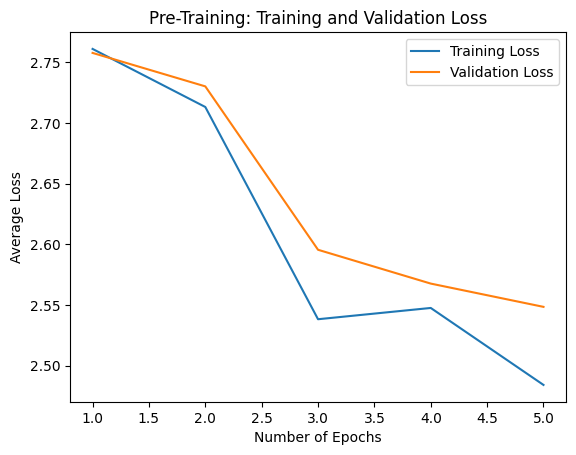

In [10]:
plt.plot(epochs, t_loss, label='Training Loss')
plt.plot(epochs, v_loss, label='Validation Loss')
plt.title('Pre-Training: Training and Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Average Loss')
plt.legend()
plt.savefig('train-validation loss')
plt.show()

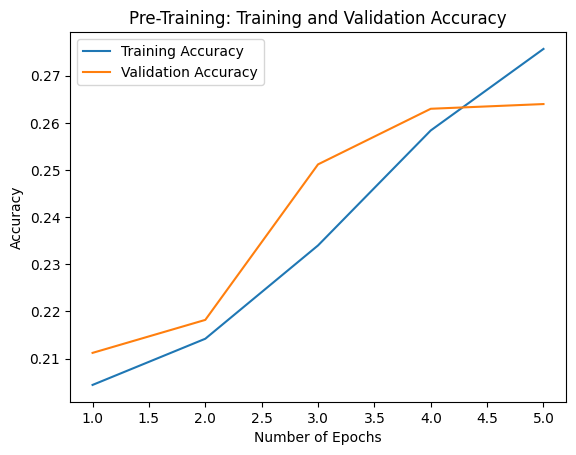

In [9]:
plt.plot(epochs, t_acc, label='Training Accuracy')
plt.plot(epochs, v_acc, label='Validation Accuracy')
plt.title('Pre-Training: Training and Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('train-validation accuracy attempt 1')
plt.show()

#Testing training attempt

In [ ]:
test_texts = test_data['text']
test_labels = test_data['label']

preprocessed_test_texts = [preprocess(text) for text in test_texts]
test_text_indices = [[word_to_idx.get(word, 1) for word in text] for text in preprocessed_test_texts]
padded_test_text_indices = [text + [0] * (max_len - len(text)) for text in test_text_indices]

print(test_texts[0])
print(preprocessed_test_texts[0])
print(idx_to_word)
print(padded_test_text_indices[0])

In [ ]:
from torch.nn.utils.rnn import pad_sequence

In [ ]:
def truncate(sequence, target_length):
  if len(sequence) < target_length:
    sequence.extend([0] * (target_length - len(sequence)))
  else:
    sequence = sequence[:target_length]
  return sequence

In [ ]:
padded_test_text_indices = [truncate(seq, 24) for seq in padded_test_text_indices]

In [ ]:
X_test = pad_sequence(torch.tensor(padded_test_text_indices, dtype=torch.long), batch_first=True)
Y_test = torch.tensor(test_data['label'], dtype=torch.long)
test_dataset = TensorDataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=100)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/Shareddrives/1470 DL Project/models_chckpt/

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('10epoch_model_chkpt.pt')

In [ ]:
ce_loss = nn.CrossEntropyLoss()

In [ ]:
evaluate(model, test_dataloader, ce_loss)

# Retraining and Testing

In [ ]:
"""Note: Followed this pytorch tutorial while implementing retraining:
https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
"""

def retrain(path, type, num_classes, train_dataloader, val_dataloader, 
            pretrain_vocab_size, retrain_vocab_size, embed_size, lstm_size, 
            window_size, hyperparameters, save_path=None):
  """
  path: file path of pretrained model
  type: full or last
  num_classes: number of classes for new task (i.e. for emotion dataset)
  train_dataloader: dataloader for training set
  val_dataloader: dataloader for validation set
  embed_size: must be same as embed size for pretrained model
  lstm_size: must be same as lstm size for pretrained model
  window_size: this is the sequence length for the retraining dataset
  save_path: if a string is provided, model will be saved to the path
  """
  model = torch.load(path)
  if type == "last":
    for param in model.parameters():
      param.requires_grad = False

  model.dense = nn.Linear(2 * lstm_size * window_size, num_classes)

  old_embedding_weights = torch.clone(model.embedding.weight)
  model.embedding = nn.Embedding(retrain_vocab_size, embed_size, padding_idx=0)

  with torch.no_grad():
    model.embedding.weight[:pretrain_vocab_size] = old_embedding_weights

  if type == "full":
    params = model.parameters()
  else:
    params = [model.dense.weight, model.dense.bias, model.embedding.weight]

  # HYPERPARAMETERS:
  learning_rate=hyperparameters.get("lr", 0.001)
  num_epochs=hyperparameters.get("num_epochs", 3)
  
  optimizer = torch.optim.Adam(params, lr=learning_rate)
  ce_loss = nn.CrossEntropyLoss()
  train(model, num_epochs, train_dataloader, val_dataloader, optimizer, ce_loss, experimenting=False)

  if save_path:
    torch.save(model, save_path) 

In [ ]:
# Training pretrained model on emotion dataset

# DEFINE RETRAIN ARGS HERE:
path = '<path of pretrained model>'
num_classes = len(set(emotion_train_labels))
pretrain_vocab_size = len(word_to_idx)
retrain_vocab_size = len(emotion_word_to_idx)
embed_size = 256
lstm_size = 500
window_size = 23
hyperparameters = {"num_epochs": 3, 
                  "lr": 0.001}

print("full")
retrain(path, "full", num_classes, emotion_train_dataloader, emotion_val_dataloader, 
            pretrain_vocab_size, retrain_vocab_size, embed_size, lstm_size, 
            window_size, hyperparameters, save_path=None)
print()
print("last")
retrain(path, "last", num_classes, emotion_train_dataloader, emotion_val_dataloader, 
            pretrain_vocab_size, retrain_vocab_size, embed_size, lstm_size, 
            window_size, hyperparameters, save_path=None)
print()
print("new")
model = DeepMojiDupe(vocab_size=len(emotion_word_to_idx), embed_size=256, lstm_size=500, window_size=window_size)
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters["lr"])
train(model, hyperparameters["num_epochs"], emotion_train_dataloader, emotion_val_dataloader, optimizer, ce_loss, experimenting=False)


In [ ]:
# Cell for testing retrained models
ce_loss = nn.CrossEntropyLoss()

print("TESTING")
print()

print("full")
val_loss, val_accuracy = evaluate(torch.load('model path'), emotion_test_dataloader, ce_loss)
print(val_loss)
print(val_accuracy)

print("last")
val_loss, val_accuracy = evaluate(torch.load('model path'), emotion_test_dataloader, ce_loss)
print(val_loss)
print(val_accuracy)

print("new")
val_loss, val_accuracy = evaluate(torch.load('model path'), emotion_test_dataloader, ce_loss)
print(val_loss)
print(val_accuracy)